## Imports

In [363]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, BatchNormalization, Dropout, Flatten, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
import numpy as np
import os
import ImageController
import Evaluator
import SaveController
import time

## Inspect the data

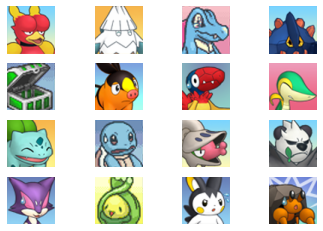

In [364]:
image_dir_url = os.path.join('data', 'smd')

ImageController.plot_random_images(image_dir_url)

## Preprocess the data

In [365]:
train_images = ImageController.load_all_images(image_dir_url).astype('float32')
# Normalize the images to a range from -1 to 1 (subtract half of the maximum value which is 255 from each value)
train_images = (train_images - 127.5) / 127.5

BUFFER_SIZE = len(train_images)
BATCH_SIZE = 256

# TODO: Was hat es mit der ersten Methode auf sich?
train_dataset = tf.data.Dataset.from_tensor_slices(tensors=train_images).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)

print('The shape of the dataset:')
train_images.shape

The shape of the dataset:


(4881, 64, 64, 3)

In [366]:
# weight_initializer = tf.keras.initializers.TruncatedNormal(stddev=0.02, mean=0)

## Setting up the generator

In [367]:
def create_generator():
    model = Sequential()

    model.add(InputLayer(input_shape=(128,)))

    # TODO: Warum wird der Bias nicht benötigt? Warum brauchen wir für jeden Graustufen-Wert ein eigenes Feature?
    model.add(Dense(units=2048, use_bias=False))

    model.add(Reshape(target_shape=(4, 4, 128)))

    model.add(Conv2DTranspose(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    assert model.output_shape == (None, 64, 64, 3)

    return model

In [368]:
NOISE_DIMENSIONS = 128
EXAMPLES_TO_GENERATE = 16

In [369]:
generator = create_generator()

print('The topography of the generator\'s model:')
generator.summary()

The topography of the generator's model:
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 2048)              262144    
_________________________________________________________________
reshape_17 (Reshape)         (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_102 (Conv2D (None, 4, 4, 512)         1638400   
_________________________________________________________________
batch_normalization_136 (Bat (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_136 (LeakyReLU)  (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_103 (Conv2D (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normal

## Here an example of the output from the untrained generator

In [370]:
# A seed is set so that each time the program is restarted the same vector is created
tf.random.set_seed(0)
# The seed is a pseudo-random vector used throughout the training to generate images and compare the generator's output between different training epochs
seed = tf.random.normal(shape=[EXAMPLES_TO_GENERATE, NOISE_DIMENSIONS])

print(seed[0])

print('The shape of the seed:')
seed.shape

tf.Tensor(
[ 1.5110626   0.42292207 -0.41969493 -1.0360372  -1.2368279   0.47027302
 -0.01397488  1.1888583   0.60253334  0.5997111  -0.7057119  -0.43297544
  0.7936245  -0.6974926  -0.95983326 -0.9006969  -0.36081055 -0.22377317
  0.30383846  0.52152544  0.1554326   1.5885501  -0.7958055   0.07794423
 -0.17937538 -0.85996604  0.21930954  0.71412295 -2.4445748   0.0267799
  1.7339767  -0.71103793  0.9271697   1.2675381  -1.8817257   0.23369557
 -0.11667552  1.0277894   0.32790193  0.26553425 -1.3359481  -1.6940202
 -0.21031012 -1.8462374   0.16966768  0.08540594 -1.4293113  -2.032579
 -1.0084237   0.3635869   0.6260673   0.8270426   0.32962734 -0.06847455
  1.0700873  -0.20061155  1.4399031  -1.7293217   0.6009366   2.2277303
 -0.28096366  0.28171858  0.23155804 -1.2104232  -0.9575648  -0.11959016
  0.28557017 -0.22965482 -1.0729516  -1.4158171  -0.7103135  -1.1485875
 -0.48121926  0.22051278  3.1314626   0.17724207  0.45234892  1.7334461
  0.18492527  0.10138129 -0.8455178  -0.0706714

TensorShape([16, 128])

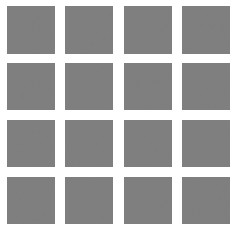

In [371]:
ImageController.generate_and_plot_images(generator, seed)

## Setting up the discriminator model

In [372]:
def create_discriminator():
    model = Sequential()

    model.add(InputLayer(input_shape=(64, 64, 3)))

    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(filters=128, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Flatten())

    model.add(Dense(units=1, activation='sigmoid'))

    return model

In [373]:
discriminator = create_discriminator()

print('The topography of the discriminator\'s model:')
discriminator.summary()

The topography of the discriminator's model:
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 32, 32, 64)        4864      
_________________________________________________________________
batch_normalization_141 (Bat (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_141 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
batch_normalization_142 (Bat (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_142 (LeakyReLU)  (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_5

## Losses definition

In [374]:
binary_crossentropy = BinaryCrossentropy()

In [375]:
def calc_discriminator_loss(real_output, fake_output):
    y_true_positive = np.ones_like(real_output).flatten()
    y_true_positive = flip_labels(y_true_positive, 0.05)
    y_true_positive = smooth_out_labels(y_true_positive, 0.3)
    y_true_positive = np.reshape(y_true_positive, (-1, 1))

    y_true_negative = np.zeros_like(fake_output).flatten()
    y_true_negative = flip_labels(y_true_negative, 0.05)
    y_true_negative = smooth_out_labels(y_true_negative, 0.3)
    y_true_negative = np.reshape(y_true_negative, (-1, 1))

    real_loss = binary_crossentropy(y_true=y_true_positive, y_pred=real_output)
    fake_loss = binary_crossentropy(y_true=y_true_negative, y_pred=fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [376]:
# If the generator does a good job the discriminator will classify the image as real  (i.e. as 1). Therefore for generator loss y_true is 1.
def calc_generator_loss(fake_output):
    return binary_crossentropy(y_true=tf.ones_like(fake_output), y_pred=fake_output)

In [377]:
def smooth_out_labels(labels, smoothness_range):
    for i, label in enumerate(labels):
        if label == 0:
            labels[i] = np.random.random() * smoothness_range
        elif label == 1:
            labels[i] = 1 - np.random.random() * smoothness_range
    return labels

In [378]:
def flip_labels(labels, flip_probability):
    for i, label in enumerate(labels):
        if flip_probability > np.random.random():
            labels[i] = 0 if label == 1 else 1
    return labels

## Optimizers definition

In [379]:
# TODO: Was genau macht beta_1?
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

## Training functions definition

In [380]:
def train_iteration(images_batch):
    noise = tf.random.normal(shape=[BATCH_SIZE, NOISE_DIMENSIONS])

    # TODO: Was ist ein GradientTape?
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images_batch = generator(noise, training=True)

        real_output = discriminator(images_batch)
        fake_output = discriminator(generated_images_batch)

        generator_loss = calc_generator_loss(fake_output)
        discriminator_loss = calc_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(target=generator_loss, sources=generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(target=discriminator_loss, sources=discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_output, fake_output, discriminator_loss, generator_loss

In [381]:
def train(image_dataset, epochs):
    training_start = time.time()
    print('TRAINING STARTED\n')

    generator_losses = []
    discriminator_losses = []
    discriminator_accuracies = []

    for epoch in epochs:
        epoch_start = time.time()

        for i, image_batch in enumerate(image_dataset):
            real_output, fake_output, discriminator_loss, generator_loss = train_iteration(image_batch)

            # At each epochs' last iteration the current metrics should be saved for future analysis
            if i == len(image_dataset) - 1:
                generator_losses.append(generator_loss)
                discriminator_losses.append(discriminator_loss)

                y_true = np.append(np.ones_like(real_output), np.zeros_like(fake_output))
                y_pred = np.append(real_output, fake_output)
                discriminator_accuracy = binary_accuracy(y_true, y_pred)
                discriminator_accuracies.append(discriminator_accuracy)

        ImageController.generate_and_save_images(generator, seed, os.path.join('generated-images', f'image_at_epoch_{epoch}'))
        SaveController.save_checkpoint_weights(epoch, generator, discriminator, generator_checkpoints_dir_url, discriminator_checkpoints_dir_url, generator_losses[-1], discriminator_losses[-1])

        epoch_end = time.time()

        print(f'Time for epoch {epoch}: {epoch_end - epoch_start} sec')
        print(f'Generator loss: {generator_losses[-1]}; Discriminator loss: {discriminator_losses[-1]}; Discriminator Accuracy: {discriminator_accuracies[-1]}\n')

    Evaluator.plot_losses(generator_losses, discriminator_losses, epochs)
    Evaluator.plot_discriminator_accuracies(discriminator_accuracies, epochs)

    training_end = time.time()

    print(f'TRAINING COMPLETED\nTotal time: {(training_end - training_start)/60} min')

## Hyperparameters

In [382]:
epochs = range(1, 301)
generator_checkpoints_dir_url = os.path.join('checkpoints', 'generator')
discriminator_checkpoints_dir_url = os.path.join('checkpoints', 'discriminator')

## Actual training

No previous weights found

TRAINING STARTED

Time for epoch 1: 7.404200553894043 sec
Generator loss: 1.1356171369552612; Discriminator loss: 1.2255843877792358; Discriminator Accuracy: 0.76953125

Time for epoch 2: 7.168959140777588 sec
Generator loss: 1.2446000576019287; Discriminator loss: 1.1083581447601318; Discriminator Accuracy: 0.923828125

Time for epoch 3: 7.106114149093628 sec
Generator loss: 1.1013208627700806; Discriminator loss: 1.1930314302444458; Discriminator Accuracy: 0.8203125

Time for epoch 4: 7.132194995880127 sec
Generator loss: 0.8586185574531555; Discriminator loss: 1.2427043914794922; Discriminator Accuracy: 0.88671875

Time for epoch 5: 7.12084174156189 sec
Generator loss: 0.8945467472076416; Discriminator loss: 1.2689120769500732; Discriminator Accuracy: 0.775390625

Time for epoch 6: 7.267053604125977 sec
Generator loss: 0.9577365517616272; Discriminator loss: 1.254789113998413; Discriminator Accuracy: 0.6796875

Time for epoch 7: 7.12516188621521 sec
Genera

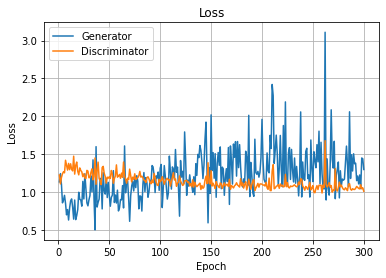

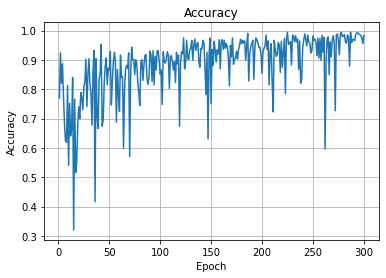

In [383]:
if SaveController.are_checkpoint_weights_available(generator_checkpoints_dir_url, discriminator_checkpoints_dir_url):
    last_completed_epoch = SaveController.load_checkpoint_weights(generator, discriminator, generator_checkpoints_dir_url, discriminator_checkpoints_dir_url)
    print(f'Continuing training from epoch {last_completed_epoch + 1}. Remaining epochs: {len(epochs) - last_completed_epoch}\n')
    train(train_dataset, epochs[last_completed_epoch:])
else:
    train(train_dataset, epochs)

In [384]:
ImageController.create_and_save_gif(image_dir_url='generated-images', output_url=os.path.join('gifs', 'pokegan.gif'))

Saved gif at: gifs\pokegan.gif
